In [2]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
from numpy.linalg import inv    
import scipy.optimize as sco
from scipy.optimize import minimize
from efficient_frontier_plot import *

import seaborn as sns
from matplotlib import font_manager, rc    
FONT_NAME = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=FONT_NAME)

In [4]:
import sys
print(sys.version)

3.11.10 | packaged by Anaconda, Inc. | (main, Oct  3 2024, 07:22:26) [MSC v.1929 64 bit (AMD64)]


In [6]:
import openpyxl
print(openpyxl.__version__)

3.1.5


In [7]:
# MV/MVP/RP/MD 모형

folder_dir = 'C:\Project\DataProcessing\Data'
DATA_FILE = "Kospi_Fin_Price_2024.xlsx"

data_wb = pd.ExcelFile(folder_dir + "/" + DATA_FILE)

adj_price = data_wb.parse("수정주가",  index_col=0)


###### 구성종목 기본사항 

In [8]:
universe =adj_price[['LG전자','현대차','NAVER','삼성물산','SK텔레콤','KT&G']].loc['2011-01-01':'2024-10-10']
df=universe.resample('M').last().pct_change(1)
print(df.head(6))

                LG전자       현대차     NAVER  삼성물산     SK텔레콤      KT&G
date                                                              
2011-01-31       NaN       NaN       NaN   NaN       NaN       NaN
2011-02-28 -0.051285 -0.005587 -0.052500   NaN -0.009126 -0.030457
2011-03-31 -0.054048  0.140449  0.010557   NaN  0.003094 -0.003490
2011-04-30 -0.019052  0.214286  0.109644   NaN -0.006133  0.110333
2011-05-31 -0.056309  0.024341 -0.096471   NaN -0.015373 -0.001577
2011-06-30 -0.147119 -0.061386 -0.015613   NaN  0.009382  0.048973


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_38236\2567290308.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df=universe.resample('M').last().pct_change(1)


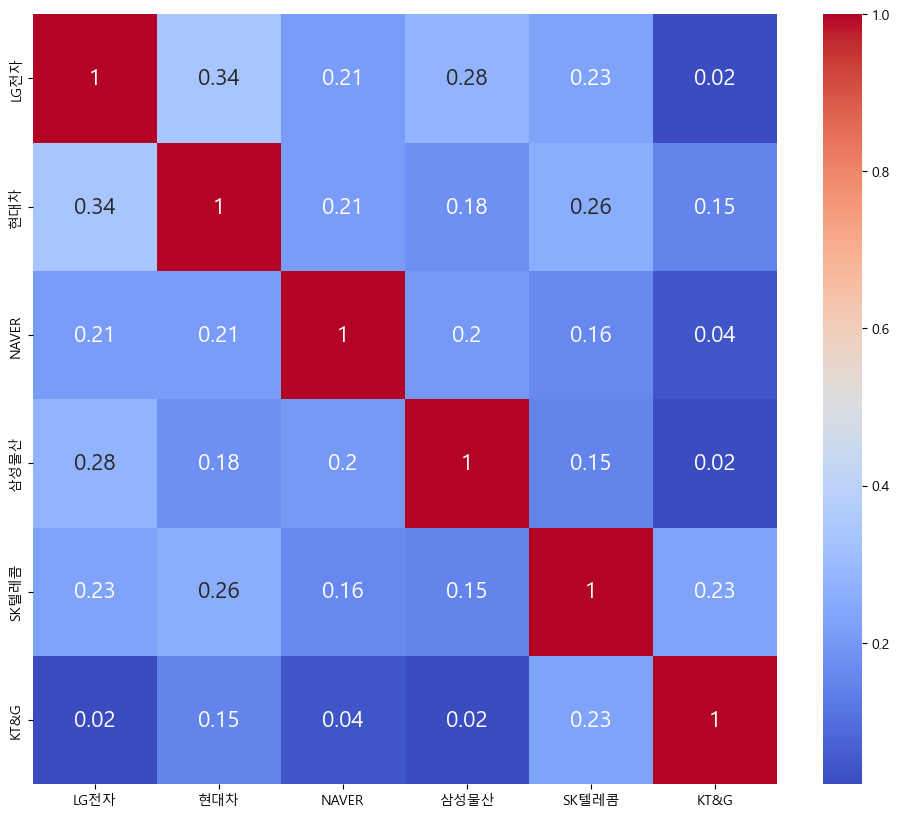

In [9]:
# 상관계수 그래프 

plt.figure(figsize=(12, 10))
sns.heatmap(df.corr().round(2), annot = True, annot_kws = {"size" : 16}, cmap='coolwarm')
plt.show()

######  모형 입력 기본값 계산

In [10]:
covmat= np.array(df.cov()*12)      #  자산별 수익률의 공분산
avg_returns= np.array(df.mean()*12)      #  종목별 기대수익률 
names=['LG전자','현대차','NAVER','삼성물산','SK텔레콤','KT&G']
n_assets = len(names)

rf = .02                           # 무위험이자율
weight=np.array(n_assets*[1/n_assets]).T  # 자산별 초기 비중
display(weight,avg_returns,covmat)

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

array([0.04299261, 0.06679156, 0.11743446, 0.02459973, 0.06633411,
       0.05850181])

array([[0.11514713, 0.03494564, 0.02234745, 0.03031682, 0.01519916,
        0.00102568],
       [0.03494564, 0.09100902, 0.01990256, 0.0167757 , 0.01538041,
        0.00863942],
       [0.02234745, 0.01990256, 0.09478971, 0.01830121, 0.00971769,
        0.00251912],
       [0.03031682, 0.0167757 , 0.01830121, 0.08278419, 0.00873921,
        0.0009714 ],
       [0.01519916, 0.01538041, 0.00971769, 0.00873921, 0.03747035,
        0.00832209],
       [0.00102568, 0.00863942, 0.00251912, 0.0009714 , 0.00832209,
        0.0355183 ]])

In [11]:
'''
# 포트폴리오 기대수익률 계산

def get_portf_rtn(w, avg_rtns):    
    return np.sum(avg_rtns * w)
    
# 포트폴리오 변동성 계산

def get_portf_vol(w, cov_mat):  
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

# 효율적 프론티어 산출 (포트폴리오수익률, 공분산행렬, 기대수익률 범위)

def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):  
    
    efficient_portfolios = []
    
    n_assets = len(avg_rtns)   # 자산갯수
    args = (cov_mat) # 함수에 들어갈 인수 정의
    
    bounds = tuple((0.0,1) for asset in range(n_assets))  # 자산별 비중 제약조건 설정
    initial_guess = n_assets * [1. / n_assets, ]          # 초기값 0.2 씩 5개 자산에 배정 
    
    for ret in rtns_range:  # 기대수익률별 최적투자비중을 산출 
        
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret}, # 포트기대수익률이 나오게 하는 X(W) 구하기
                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 자산별 비중합은 1
        efficient_portfolio = minimize(get_portf_vol, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

# 프론티어를 구성하는 변동성, 기대수익률, 자산별 투자비중 값 구기기

def get_efficient_frontier_value(avg_rtns, cov_mat,nums): # nums: 기대수익률 갯수
    
    # 효율적 프론티어에 표현할 기대수익률의 범위 설정
    rtns_range=  np.linspace(min(avg_rtns),max(avg_rtns), nums)  
    
    # 효율적 프론티어 함수 실행 
    efficient_portfolios = get_efficient_frontier(avg_rtns,cov_mat,rtns_range)
    vols_range = [x['fun'] for x in efficient_portfolios] # 포트폴리오 변동성 추출
    weight_range = [x['x'] for x in efficient_portfolios] # 자산별 최적비중 추출

    # 위 함수에서 계산된 값들을  데이터 프레임화
    
    pvx=pd.DataFrame(vols_range)  #  변동성 범위
    prt=pd.DataFrame(rtns_range)  #  기대수익률 범위
    pw=pd.DataFrame(weight_range) #  자산별 비중
   
     # 위 자료 합치기 
    portfolio_result_df=pd.concat([pvx,prt,pw],axis=1,join='outer')  
      
   # 리스크 최소값에 해당하는 기대수익률 찾기  (프론티어 시작점)
    exp_ret= portfolio_result_df[portfolio_result_df.iloc[:,0]==portfolio_result_df.iloc[:,0].min()].iloc[:,1].min()
    port_result = portfolio_result_df[portfolio_result_df.iloc[:,1]>= exp_ret]  # 프론티어 도출

    return round( port_result,4)
    
'''

"\n# 포트폴리오 기대수익률 계산\n\ndef get_portf_rtn(w, avg_rtns):    \n    return np.sum(avg_rtns * w)\n    \n# 포트폴리오 변동성 계산\n\ndef get_portf_vol(w, cov_mat):  \n    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))\n\n# 효율적 프론티어 산출 (포트폴리오수익률, 공분산행렬, 기대수익률 범위)\n\ndef get_efficient_frontier(avg_rtns, cov_mat, rtns_range):  \n    \n    efficient_portfolios = []\n    \n    n_assets = len(avg_rtns)   # 자산갯수\n    args = (cov_mat) # 함수에 들어갈 인수 정의\n    \n    bounds = tuple((0.0,1) for asset in range(n_assets))  # 자산별 비중 제약조건 설정\n    initial_guess = n_assets * [1. / n_assets, ]          # 초기값 0.2 씩 5개 자산에 배정 \n    \n    for ret in rtns_range:  # 기대수익률별 최적투자비중을 산출 \n        \n        constraints = ({'type': 'eq', \n                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret}, # 포트기대수익률이 나오게 하는 X(W) 구하기\n                       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # 자산별 비중합은 1\n        efficient_portfolio = minimize(get_portf_vol, initial_guess, \n                                    

In [34]:
# 프론티어 구성하는 계산값 구기기

port_result_df = get_efficient_frontier_value(avg_returns, covmat, 100)

In [36]:
port_result_df.head(5)

,0,0,0,1,2,3,4,5
40,0.1319,0.0621,0.0433,0.0427,0.1018,0.1270,0.2848,0.4005
41,0.1320,0.0630,0.0406,0.0436,0.1115,0.1189,0.2902,0.3953
42,0.1322,0.0640,0.0378,0.0447,0.1217,0.1109,0.2920,0.3929
43,0.1324,0.0649,0.0351,0.0458,0.1319,0.1029,0.2938,0.3904
44,0.1328,0.0659,0.0324,0.0468,0.1421,0.0949,0.2957,0.3881


In [37]:
# 프론티어에 필요한 변동성과 기대수익률만 따로 추린다.

port_result=port_result_df.iloc[:,[0,1]]  # 포트폴리오 변동성과 기대수익률
port_result.columns=['portf_vol', 'portf_rtns']

##### 효율적 프론티어 그리기

C:\Anaconda\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


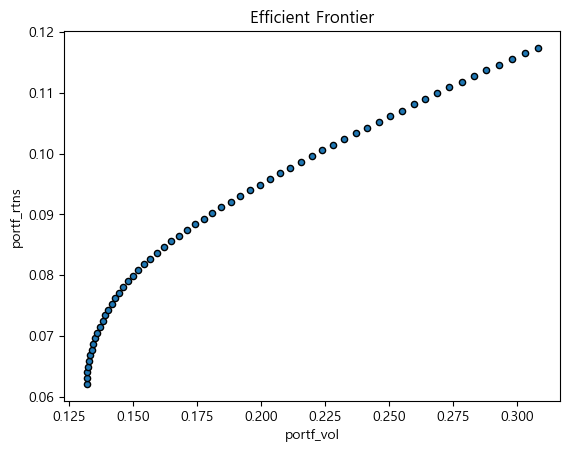

In [39]:
fig, ax = plt.subplots()
port_result.plot(kind='scatter', x='portf_vol', 
                      y='portf_rtns', 
                      cmap='RdYlGn', edgecolors='black', title='Efficient Frontier', 
                      ax=ax)
plt.show()

##### 포트폴리오 기대수익률 수준에 따른 자산별 투자비중 변화

In [40]:
portfolio_weight_df= port_result_df.iloc[:,[2,3,4,5,6,7]]  #  # 효율적 포트폴리오 결과치에서 자산별 비중만 추출
portfolio_weight_df.columns=df.columns  # 자산명 

# 포트폴리오 기대수익률과 자산별 투자비중의 결합
port_all=  pd.concat([portfolio_weight_df, port_result[['portf_rtns']]],axis=1)
opt_port= port_all.set_index('portf_rtns')

# 포트폴리오 기대수익률에 따른 자산별 투자비중 변화 그래프 
opt_port.plot.bar(stacked=True,legend='reverse', figsize=(12,8))

<Axes: xlabel='portf_rtns'>

##### 1. Minimum Variance  Portfolio =MVP

In [17]:
# 포트폴리오 변동성 계산

def get_portf_vol(weight, cov_mat):
    return np.sqrt(np.dot(weight.T, np.dot(cov_mat, weight)))

In [18]:
get_portf_vol(weight,covmat)

0.15660688749802476

In [19]:
# 포트폴리오 변동성 최소화를 위한 최적화 

def minimum_variance_optimization(returns,cov_mat):
    
    num_assets=len(returns) # 자산갯수 
    args=(cov_mat)          # 공분산 입력
    constraints=({'type': 'eq','fun': lambda x: np.sum(x)-1})
    bounds=[(0,1) for i in range(num_assets)]  # 자산별 비중 제약 (0, 1)
    
    result_mv= sco.minimize(get_portf_vol,num_assets*[1./num_assets],args=args, method='SLSQP',
                         bounds=bounds,constraints=constraints)
    MVO_Allocation =pd.DataFrame(result_mv.x,index=df.columns,columns=['allocation'])  # 종목명 인덱스만 가져다 쓴다.
    
    return round(MVO_Allocation*100,2)


In [20]:
# 함수 결과값 확인

MVO =minimum_variance_optimization(avg_returns,covmat)
print(MVO)
MVO.plot.barh(figsize=(7, 2), legend=False)


       allocation
LG전자         4.39
현대차          4.22
NAVER        9.99
삼성물산        12.82
SK텔레콤       28.50
KT&G        40.07


<Axes: >

#### 2. Maximum Sharpe Ratio Portfolio(최대 샤프비율 포트폴리오)
        = Tangent Portfolio

최대샤프지수 포트폴리오(Maximum Sharpe Ratio Portfolio)란 샤프지수가 최대가 되도록 하는 포트폴리오를 구성하는 것이다. 샤프지수는 $\frac{R_p-R_f}{\sigma_p}$, 즉 포트폴리오의 수익을 변동성으로 나눈 값이며, 위험 대비 수익률이라고도 볼 수 있다. 따라서 샤프지수가 최대가 되는 포트폴리오는 위험은 낮으면서 수익은 높은 포트폴리오를 말한다. 

In [21]:
# 목적함수인 (-) 샤프비율을 구하는 함수 

def sharpe_ratio(weight,returns,cov_mat,rf):
    ret=np.sum(returns*weight)                            #  포트폴리오 기대수익률 
    std=np.sqrt(np.dot(weight.T,np.dot(cov_mat,weight)))   # 포트폴리오 리스크 (변동성)
    sharpe =-(ret-rf)/std                                 # 최소화--> 최대화 되므로 마이너스 붙인다.
    return sharpe
    
# 함수 결과 값 확인하기
gg= sharpe_ratio(weight,avg_returns,covmat,0.02)
print(gg)


-0.2731406913158349


In [22]:
# (-)샤프비율을 최소화하기 위한 최적화 함수  = (+) 샤프비율을 최대화

def mean_variance_optimization(returns,cov_mat,rf):  # ( 포트폴리오 기대수익률, 공분산, 무위험이자율)
    
    num_assets=len(returns)
    args=(returns,cov_mat,rf)
    constraints=({'type': 'eq','fun': lambda x: np.sum(x)-1})
    bounds=[(0,1) for i in range(num_assets)]
    
    result= sco.minimize(sharpe_ratio,num_assets*[1./num_assets,],args=args, method='SLSQP',
                         bounds=bounds,constraints=constraints)
    Sharp_Allocation =pd.DataFrame(result.x,index=df.columns,columns=['allocation'])  # 종목명 인덱스만 가져다 쓴다.
    
    return round(Sharp_Allocation*100,2)  



In [23]:
# 함수 결과값  그래프 확인하기

sharp = mean_variance_optimization(avg_returns,covmat,rf)
print(sharp)
sharp.plot.barh(figsize=(7, 2), legend=False)



       allocation
LG전자         0.00
현대차          4.16
NAVER       34.76
삼성물산         0.00
SK텔레콤       29.78
KT&G        31.29


<Axes: >

#### 3. Risk parity portfolio (위험균형 포트폴리오)


포트폴리오를 구성하는 자산들과 전체 위험의 관계를 이해하기 위해서는, 먼저 한계 위험기여도(MRC: Marginal Risk Contribution)와 위험기여도(RC: Risk Contribution)에 대해 알아야 한다. 한계 위험기여도는 특정 자산의 비중을 한 단위 증가시켰을 때 전체 포트폴리오 위험의 증가를 나타내는 단위로서, 수학의 편미분과 같은 개념이다. $i$번째 자산의 한계 위험기여도는 아래와 같이 나타낼 수 있다.

$$MRC_i = \frac{\partial\sigma_p}{\partial w_i} $$

$\sqrt {f'(x)} = \frac{f'(x)}{2\sqrt{f(x)}}$인 사실을 이용하면, 한계 위험기여도는 다음과 같이 풀 수 있다. 결과적으로 분자는 분산-공분산 행렬과 각 자산의 비중의 곱, 분모는 포트폴리오의 표준편차 형태로 나타난다.

$$
\begin{equation} 
\begin{split}
\frac{\partial\sigma_p}{\partial w} & = \frac{\partial(\sqrt{w'\Omega w})}{\partial w} \\
& =\frac{\partial(w'\Omega w)}{\partial w} \times \frac{1}{2\sqrt{w'\Omega w}} \\
& =\frac{2\Omega w}{2\sqrt{w'\Omega w}} \\
& =\frac{\Omega w}{\sqrt{w'\Omega w}}
\end{split}
\end{equation} 
$$

위험기여도는 특정 자산이 포트폴리오 내에서 차지하는 위험의 비중이다. 한계 위험기여도가 큰 자산도 포트폴리오 내에서 비중이 작다면, 포트폴리오 내에서 차지하는 위험의 비중은 작을 것이다. 반면에, 한계 위험기여도가 작은 자산일지라도 비중이 압도적으로 많다면, 포트폴리오 내에서 차지하는 위험의 비중은 클 것이다. 결과적으로 $i$번째 자산의 위험기여도는, $i$번째 자산의 한계 위험기여도와 포트폴리오 내 비중의 곱으로 이루어진다.

$$RC_i = \frac{\partial\sigma_p}{\partial w_i} \times w_i$$

특정 자산이 포트폴리오의 위험을 대부분 차지하는 문제를 막고, 모든 자산이 동일한 위험기여도를 가지는 포트폴리오가 위험균형 포트폴리오(Risk Parity Portfolio) 혹은 동일 위험기여도 포트폴리오(Equal Risk Contribution Portfolio)다. 이를 수식으로 쓰면 다음과 같습니다.

$$RC_1 = RC_2 = \dots = RC_n$$
$$\frac{\partial\sigma_p}{\partial w_1} \times w_1 = \frac{\partial\sigma_p}{\partial w_2} \times w_2
= \dots = \frac{\partial\sigma_p}{\partial w_n} \times w_n = \frac{\sigma_p}{n}$$

In [24]:
# 자산별 리스크 기여도를 구하기 위한 함수

def Risk_Contribution(weight,cov_mat) :
    # weight =np.array(weight)
    std=np.sqrt(np.dot(weight.T,np.dot(cov_mat,weight)))  # 포트폴리오 리스크 (변동성)
    mrc=np.dot(cov_mat,weight)/std                        # 한계기여도 = (공분산*자산별 비중)/포트폴리오 리스크
    rc=weight*mrc
    return rc, std


In [25]:
# 리스크 기여도 함수 결과 값 확인하기
rcc=Risk_Contribution(weight,covmat) 
print(rcc)


(array([0.0388414 , 0.03310709, 0.02972371, 0.02800511, 0.01682005,
       0.01010953]), 0.15660688749802476)


In [26]:
def risk_parity_target(weight) :
    
    rc,std=Risk_Contribution(weight,covmat)
    RC_assets=rc
    RC_target=std/len(rc)
    objective_fun=np.sum(np.square(RC_assets-RC_target.T))
    
    return objective_fun


In [27]:
# 타깃 함수 결과값 확인하기

op=risk_parity_target(weight)
print(op)

0.0005700155734211297


In [28]:
# 포트폴리오의 자산별 리스크 기여도를 동일하게 하는 자산별 비중

def risk_parity_optimization(cov_matrix):
    
    TOLERANCE= 1e-20
    num_assets=len(cov_matrix)
    constraints=({'type': 'eq','fun': lambda x: np.sum(x)-1.0},{'type': 'ineq','fun': lambda x: x})  
    result=sco.minimize(risk_parity_target,num_assets*[1./num_assets,],method='SLSQP',
                       constraints=constraints, tol=TOLERANCE)    
    RP_Allocation=pd.DataFrame(result.x,index=df.columns,columns=['allocation'])
 
    return  round(RP_Allocation*100,2)              


In [29]:
# 함수 결과 값 확인하기

RP= risk_parity_optimization(covmat)
print(RP)
RP.plot.barh(figsize=(7, 2), legend=False)


       allocation
LG전자        11.60
현대차         12.70
NAVER       14.05
삼성물산        14.83
SK텔레콤       20.56
KT&G        26.24


<Axes: >

#### 4. Maximum Diversification  (최대분산 포트폴리오)

포트폴리오 분산비율( 자산별 비중가중한 변동성 /포트폴리오 변동성))을 최대화하는 자산별 비중을 구한다. 
여기서 분자>분모 이므로 상관관계가 낮은 자산으로 포트폴리오를 구성할수록 
분모가 분자에 가까와져 분산비율은 1에 가까워지게 됨.

In [30]:
def diversification_ratio(weight, cov_mat):
    w_vol = np.dot(np.sqrt(np.diag(cov_mat)), weight.T)  # 비중가중 변동성 
    port_vol = np.sqrt(weight.T @ covmat @ weight)       # 포트폴리오 변동성
    diversification_ratio = w_vol/port_vol
    return -diversification_ratio

In [31]:
# 포트폴리오 분산을 최소화 하기 위한 자산별 비중을 구하는 함수

def Most_Diversified(cov_mat, lb, ub):
    x0 = np.repeat(1/cov_mat.shape[1], cov_mat.shape[1]) 
    lbound = np.repeat(lb, cov_mat.shape[1]) # 하단 경계 [0,0,..0]
    ubound = np.repeat(ub, cov_mat.shape[1])  # 상단 경계 [1,1,..1] 
    bnds = tuple(zip(lbound, ubound))         # ((0,1),(0,1)...(0,1))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1.0})
           
    options = {'ftol': 1e-20, 'maxiter': 800}   # 허용수준, 최대반복 횟수
    result =sco.minimize(fun = diversification_ratio,
                      x0 = x0,
                      args = cov_mat,
                      method = 'SLSQP',
                      constraints = constraints,
                      options = options,
                      bounds = bnds)
    MD_Allocation=pd.DataFrame(result.x,index=df.columns,columns=['allocation'])
    
    return round( MD_Allocation*100,2)   

In [32]:
# 함수 결과 값 확인하기

MD= Most_Diversified(covmat,0.0,1.0)
print(MD)
MD.plot.barh(figsize=(7, 2), legend=False)

       allocation
LG전자        10.28
현대차          9.45
NAVER       14.98
삼성물산        15.59
SK텔레콤       16.91
KT&G        32.79


<Axes: >